### Using Tree data

In [82]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import gaussian_process
from sklearn.gaussian_process.kernels import *
import seaborn as sns

dendro = pd.read_feather("data/17766_12_D.feather")
dendro

,dendroNr,DOY,hour,species,growth
0,HA_001_2012,0,0.0,Beech,0.000
1,HA_001_2012,1,0.5,Beech,0.000
2,HA_001_2012,2,1.0,Beech,0.000
3,HA_001_2012,3,1.5,Beech,0.000
4,HA_001_2012,4,2.0,Beech,0.000
...,...,...,...,...,...
1457969,SH_076_2013,8779,21.5,Beech,3902.797
1457970,SH_076_2013,8780,22.0,Beech,3902.797
1457971,SH_076_2013,8781,22.5,Beech,3903.275
1457972,SH_076_2013,8782,23.0,Beech,3903.275


# Fit models

In [3]:
%%capture
# Import my GP
%run ./GP.ipynb

OptStep(params=Array([1.99894079e+03, 2.16786146e-04, 3.30283655e+00], dtype=float64), state=ScipyMinimizeInfo(fun_val=Array(32.31305416, dtype=float64, weak_type=True), success=True, status=0, iter_num=18))


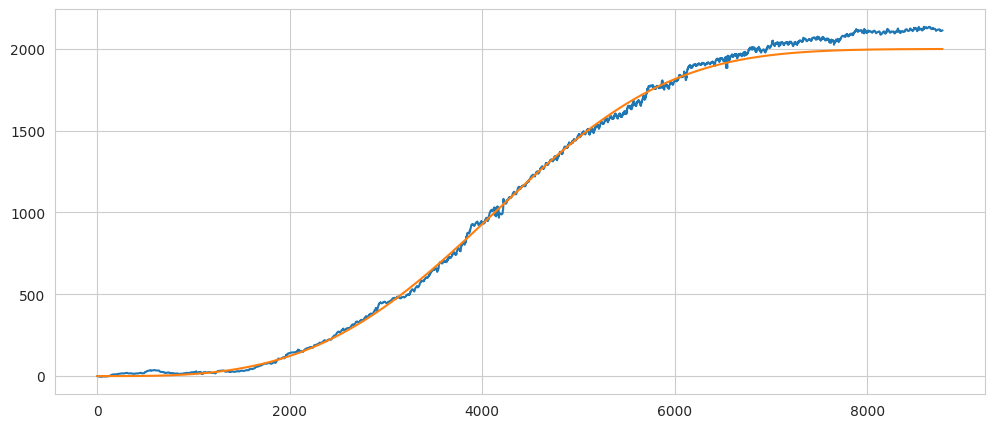

In [97]:
import jaxopt
import jax
import jax.numpy as jnp

dendro_spcs = dendro[dendro.species.eq("Beech")]

def weibull_F(x, lambda_, k_):
    return 1 - jnp.exp(-(lambda_ * x) ** k_)

#weibull = lambda x: 1500 * weibull_F(x.ravel(), 1/95, 3.5)#2100 * weibull_F(x.ravel(), 1 / 100, 5)  # Not accurate on to give the isotropic kernel a purpose

df_ = dendro_spcs.groupby("DOY", as_index = False).mean(numeric_only=True)
y_ = jnp.array(df_.growth)
x_ = jnp.array(df_.DOY)

def f_(params):
    p0, p1, p2 = params
    return jnp.mean(jax.vmap(jaxopt.loss.huber_loss)(y_, p0 * weibull_F(x_, p1, p2)))

solver = jaxopt.ScipyBoundedMinimize(fun = jax.tree_util.Partial(f_))
res = solver.run(jnp.array([2000.0, 1/5, 3]), jnp.array([(1e1, 1e-6, 1e-1), (1e5, 1e0, 1e2)]))
weibull = lambda x__ : res.params[0] * weibull_F(x__.ravel(), res.params[1], res.params[2])

print(res)
plt.figure(figsize=(12,5))
plt.plot(x_, y_)
plt.plot(x_, weibull(x_))
plt.show()

250
247


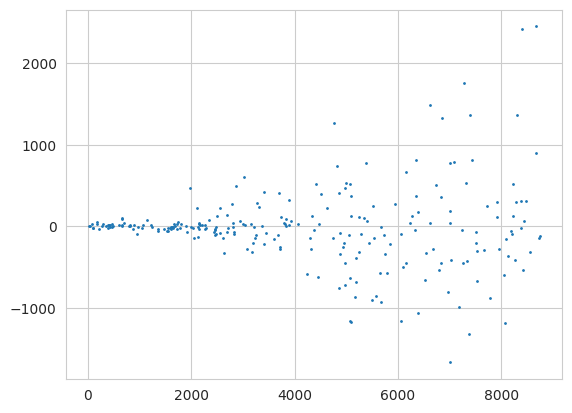

In [107]:
N = 250

rng = np.random.default_rng()
train_idx = np.sort(rng.integers(0, len(dendro_spcs), N))
print(len(train_idx))
dendro_spcs_sample = dendro_spcs.sort_values("DOY", ignore_index=True).loc[train_idx]

X_train = dendro_spcs_sample.groupby("DOY", as_index = False).mean(numeric_only=True).DOY.array.reshape(-1, 1)
y_train = dendro_spcs_sample.groupby("DOY", as_index = False).mean(numeric_only=True).growth.array
print(len(y_train))
mean_prior = weibull(X_train)
y_train -= mean_prior

plt.scatter(X_train, y_train, s = 1)

In [110]:
kernel_ = ConstantKernel(15**2) * Matern(2, nu = 5/2) + WhiteKernel(2e3) + RBF(1e-4) * ExpSineSquared(0.2, 1e3)
gp_model = gaussian_process.GaussianProcessRegressor(
    kernel=kernel_,
    n_restarts_optimizer=2,
    #normalize_y=True,
    #optimizer=None
)

gp_model.fit(X_train, y_train)
gp_model.kernel_, gp_model.log_marginal_likelihood_value_

/root/anaconda3/envs/3.11-liesel/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k1__k1__constant_value is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/root/anaconda3/envs/3.11-liesel/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__noise_level is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/root/anaconda3/envs/3.11-liesel/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:420: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__k2__periodicity is close to the specified lower bound 1e-05. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(


(316**2 * Matern(length_scale=0.0928, nu=2.5) + WhiteKernel(noise_level=1e+05) + RBF(length_scale=745) * ExpSineSquared(length_scale=0.614, periodicity=1e-05),
 -1884.8328927140542)

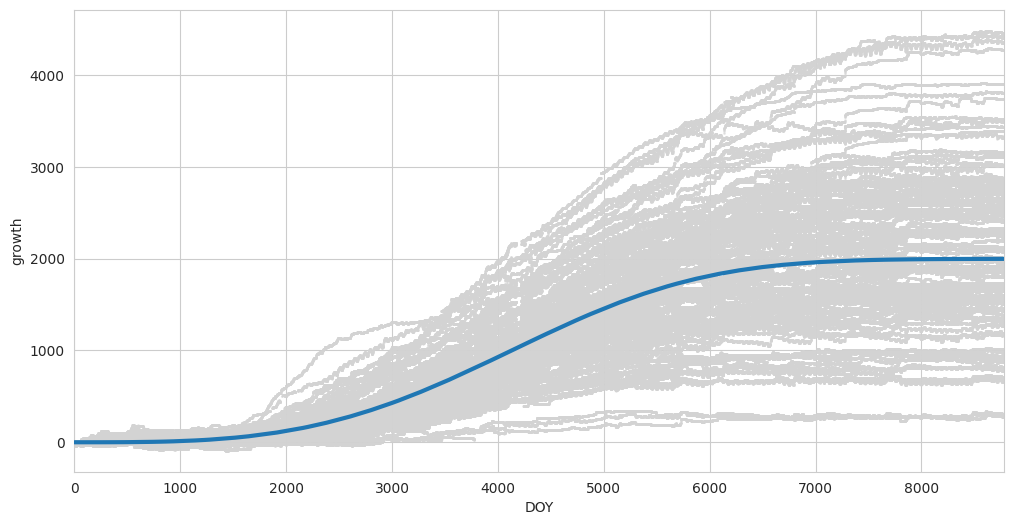

In [109]:
plt.figure(figsize=(12, 6))
X_test = np.linspace(0, dendro_spcs.DOY.max(), 5000).reshape(-1, 1)

#print(gp_model.kernel_)
mean_pred, std_pred = gp_model.predict(X_test, True)
#y_samples = gp_model.sample_y(X_test, 1)

mean_pred += weibull(X_test)
plt.plot(
    X_test, mean_pred, lw=3, zorder=10
)

# sns.lineplot(data=dendro_spcs, x="DOY", y="growth", units="dendroNr", lw=0.8, estimator=None, c="lightgray", alpha=0.3,
#              zorder=-3
#              )
plt.scatter(dendro_spcs.DOY, dendro_spcs.growth,c ="lightgray", alpha=0.5, s = 1)
# plt.fill_between(
#     X_test.ravel(),
#     mean_pred - 1.96 * std_pred,
#     mean_pred + 1.96 * std_pred,
#     color="k", alpha=.1, zorder=0,
# )
# for idx, single_prior in enumerate(y_samples.T):
#     plt.plot(
#         X_test, single_prior + weibull(X_test)
#         , alpha=.4, lw=1, linestyle="dashed"
#     )
#plt.plot(X_train, y_train + weibull(X_train), c = "r")
plt.xlabel("DOY")
plt.ylabel("growth")
plt.xlim(0, dendro_spcs.DOY.max())
plt.show()